<a href="https://colab.research.google.com/github/pullz6/Airline_Study/blob/main/Airline_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all libraires and the dataset.

In [1]:
import pandas as pds
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy import geocoders
!pip uninstall kmodes && pip install kmodes
from kmodes.kmodes import KModes
from kmodes import kprototypes
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

drive.mount('/content/drive')

file = ('/content/drive/MyDrive/sample_data/Thesis/capstone_airline_reviews3.xlsx')
file_1 = ('/content/drive/MyDrive/sample_data/Thesis/reviews_data.csv')
file_2 = ('/content/drive/MyDrive/sample_data/Thesis/rating_data.csv')
airline = pds.read_excel(file)
airline = airline.dropna()
airline = airline.reset_index(drop=True)
ba_reviews = pds.read_csv(file_1)
ba_ratings = pds.read_csv(file_2)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 1s (459 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unp

Passenger Segmentation

Cleaning the customer reviews in the dataset from unwanted information or characaters.

In [2]:
airline.drop('author',axis=1,inplace=True)
airline['Verified'] = np.where(airline['customer_review'].str.contains('Trip Verified'), True, False)
airline.drop('review_date',axis=1,inplace=True)
airline["customer_review"] = airline["customer_review"].str.replace("âœ… Trip Verified |","")
airline["customer_review"] = airline["customer_review"].str.replace("Not Verified |","")
airline["customer_review"] = airline["customer_review"].str.replace("âœ… Verified","")
airline["customer_review"] = airline["customer_review"].str.replace("|","")
airline['date_flown']=pd.to_datetime(airline['date_flown'].astype(str))

<ipython-input-2-fee9a194e3a2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  airline["customer_review"] = airline["customer_review"].str.replace("âœ… Trip Verified |","")
<ipython-input-2-fee9a194e3a2>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  airline["customer_review"] = airline["customer_review"].str.replace("Not Verified |","")
<ipython-input-2-fee9a194e3a2>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  airline["customer_review"] = airline["customer_review"].str.replace("|","")


Adding an attribute for customers who are transiting.

In [3]:
airline_1 = pd.DataFrame(airline.route.str.split(' to ',1).tolist(),columns = ['fips','row'])
airline['Start'] = airline_1['fips']
airline['row'] = airline_1['row']
airline['Transit'] = airline['row'].str.contains('via')
airline['Destination'] = airline['row'].str.split(' ').str[-1]
airline['Destination']  = airline['Destination'] .str.replace(r'\W', '')
airline.drop('row',inplace=True,axis=1)

<ipython-input-3-8ce39dc653bc>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  airline_1 = pd.DataFrame(airline.route.str.split(' to ',1).tolist(),columns = ['fips','row'])
<ipython-input-3-8ce39dc653bc>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  airline['Destination']  = airline['Destination'] .str.replace(r'\W', '')


Creating an attribute for the type of aircraft that a passenger is flying in.

In [4]:
conditions = [
    airline["aircraft"].str.contains('Boeing') & airline["aircraft"].str.contains('A')  == True,
    airline["aircraft"].str.contains('|'.join(['Boeing', 'boeing','B','Dreamliner','dreamliner'])) == True,
    airline["aircraft"].str.contains('A') == True
]
choices = ['Both','Boeing','Airbus']
airline['aircraft_manu'] = np.select(conditions, choices)

In [5]:
airline['aircraft_manu'] = np.where(airline['aircraft_manu']=='0', 'Other', airline['aircraft_manu'])

In [6]:
airline['aircraft_manu'].unique()

array(['Airbus', 'Both', 'Boeing', 'Other'], dtype=object)

Creating an attribute for the season that the passenger flew in.

In [7]:
airline['month'] = airline.date_flown.dt.month

def find_season(month):
        season_month = {
            12:'Winter', 1:'Winter', 2:'Winter',
            3:'Spring', 4:'Spring', 5:'Spring',
            6:'Summer', 7:'Summer', 8:'Summer',
            9:'Autumn', 10:'Autumn', 11:'Autumn'}
        return season_month.get(month)

season_list = []
for month in airline['month']:
    season = find_season(month)
    season_list.append(season)

airline['Season'] = season_list

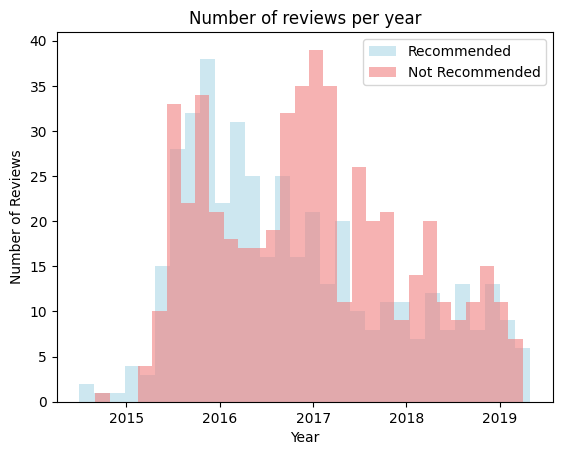

In [8]:
#to group it per year, take hte mean value per year for Brisith Airways.
plt.figure()
bae = airline[airline['airline'].str.contains('British Airways')]
plt.hist(bae['date_flown'][bae['recommended']=='yes'],bins=30,color = "lightblue",label='Recommended',alpha=0.6)
plt.hist(bae['date_flown'][bae['recommended']=='no'],bins=30,color = "lightcoral",label='Not Recommended',alpha=0.6)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of reviews per year')
plt.show()

In [9]:
airline['airline'].unique()
#filtering the selected airlines
selected_airlines = airline[airline['airline'].isin(['Qatar Airways', 'Emirates', 'Lufthansa', 'KLM Royal Dutch Airlines','American Airlines','Air France','Etihad Airways','British Airways'])]
#resetting the index of the dataset
selected_airlines.reset_index(drop = True, inplace=True)
#dropping features we are not interested in.
selected_airlines = selected_airlines.drop(['customer_review','aircraft','traveller_type','cabin','route','date_flown','seat_comfort','cabin_service','food_bev','entertainment','ground_service','value_for_money','Verified','Start','Destination','aircraft_manu','Transit','Season','month'], axis=1)

In [10]:
selected_airlines

,airline,overall,recommended
0,Qatar Airways,6.0,yes
1,Qatar Airways,9.0,yes
2,Qatar Airways,9.0,yes
3,Qatar Airways,10.0,yes
4,Qatar Airways,4.0,yes
...,...,...,...
4358,Etihad Airways,1.0,no
4359,Etihad Airways,7.0,yes
4360,Etihad Airways,3.0,no
4361,Etihad Airways,1.0,no


In [11]:
#removing datapoints that has no in recommendations
index_names = selected_airlines[selected_airlines['recommended'].isin(['no'])].index
#resetting the index
selected_airlines.drop(index_names,inplace=True)

In [12]:
#creating a dataframe with just the mean value of the overal rating for each airline and counting the number of recommendations.
selected_airlines = selected_airlines.groupby('airline').agg({'overall':'mean','recommended':'count'})
#getting the average mean
mean_overall = selected_airlines['overall'].mean()
#getting the mean of all the recommendations
mean_recomm = selected_airlines['recommended'].mean()

Text(0.5, 1.0, 'Quadrant Analysis on Popular Airlines')

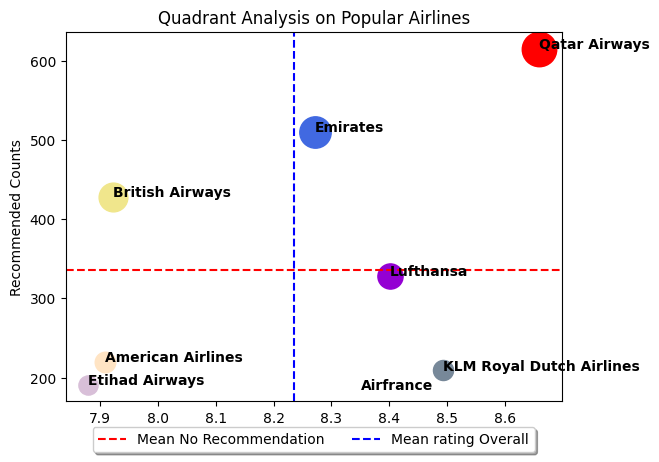

In [13]:
#colors for each alirline
color = ['lightcoral','bisque','khaki','royalblue','thistle','lightslategrey','darkviolet','red']
#labels or the. names of each airline
labels = ['Airfrance','American Airlines','British Airways','Emirates','Etihad Airways','KLM Royal Dutch Airlines','Lufthansa','Qatar Airways']
#starting the plotting with a figure
fig = plt.figure()
ax1 = fig.add_subplot(111)
x_cor=[]
y_cor=[]
z = 0
#loop the labels, find the matching airline in that label and plot that point
for i in labels:
  group = selected_airlines[selected_airlines.index.str.contains(i)]
  group.plot.scatter(x='overall', y='recommended', c=color[z], s = 'recommended', ax=ax1)
  value_1= group['overall'].to_numpy()
  value_2 = group['recommended'].to_numpy()
  #save the point coordinates
  x_cor.append(value_1.astype(int))
  y_cor.append(value_2.astype(int))
  z= z+1
x_cor = selected_airlines['overall'].squeeze()
y_cor= selected_airlines['recommended'].squeeze()
#plot the labels
for i, txt in enumerate(labels):
    ax1.annotate(txt, (x_cor[i], y_cor[i]), weight='bold')
#detailing the plot
plt.ylabel('Recommended Counts')
plt.xlabel('Mean Rating')
plt.axhline(y=mean_recomm, color="red", linestyle="--",label='Mean No Recommendation')
plt.axvline(x=mean_overall, color="blue", linestyle="--",label = 'Mean rating Overall')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Quadrant Analysis on Popular Airlines", fontsize=12)

In [14]:
airports = pd.read_csv('/content/drive/MyDrive/sample_data/Thesis/GlobalAirportDatabase.txt', sep=":", header=None)
airports.columns = ["ICAO Code", "IATA Code", "Airport Name", "City/Town",'Country','Latitude Degrees','Latitude Minutes','Latitude Seconds','Latitude Direction','Longitude Degrees','Longitude Minutes','Longitude Seconds','Longitude Direction','Altitude','Latitude Decimal Degrees','Longitude Decimal Degrees']

In [15]:
airports['City/Town'] = airports['City/Town'].str.title()
airports['Airport Name'] = airports['Airport Name'].str.title()
airports['Country'] = airports['Country'].str.title()
airports = airports.replace(np.nan, '', regex=True)

Assigning, country, latitude and longitude for the start and destination

In [16]:
airports.head()

,ICAO Code,IATA Code,Airport Name,City/Town,Country,Latitude Degrees,Latitude Minutes,Latitude Seconds,Latitude Direction,Longitude Degrees,Longitude Minutes,Longitude Seconds,Longitude Direction,Altitude,Latitude Decimal Degrees,Longitude Decimal Degrees
0,AYGA,GKA,Goroka,Goroka,Papua New Guinea,6,4,54,S,145,23,30,E,1610,-6.082,145.392
1,AYLA,LAE,,Lae,Papua New Guinea,0,0,0,U,0,0,0,U,0,0.000,0.000
2,AYMD,MAG,Madang,Madang,Papua New Guinea,5,12,25,S,145,47,19,E,7,-5.207,145.789
3,AYMH,HGU,Mount Hagen,Mount Hagen,Papua New Guinea,5,49,34,S,144,17,46,E,1643,-5.826,144.296
4,AYNZ,LAE,Nadzab,Nadzab,Papua New Guinea,6,34,11,S,146,43,34,E,73,-6.570,146.726


In [17]:
def find_country_and_lat_long(x):
  """ This function is built to provide the longitude and latitude as well as the country of the passegner's starting and destination airports
  """
  country = 'Unknown'
  if len(x) == 3:
    selection = airports[airports['IATA Code']==x]
    country = selection['Country'].iloc[:1]
    country = country.to_list()
    country = "".join(country)
    long = selection['Longitude Decimal Degrees'].iloc[:1]
    long = long.to_list()
    lat = selection['Latitude Decimal Degrees'].iloc[:1]
    lat = lat.to_list()
  elif len(x) == 4:
    selection = airports[airports['ICAO Code']==x]
    country = selection['Country'].iloc[:1]
    country = country.to_list()
    country = "".join(country)
    long = selection['Longitude Decimal Degrees'].iloc[:1]
    long = long.to_list()
    lat = selection['Latitude Decimal Degrees'].iloc[:1]
    lat = lat.to_list()
  else:
    selection = airports[airports['Airport Name'].str.contains(x)]
    country = selection['Country'].iloc[:1]
    country = country.to_list()
    country = "".join(country)
    long = selection['Longitude Decimal Degrees'].iloc[:1]
    long = long.values.tolist()
    lat = selection['Latitude Decimal Degrees'].iloc[:1]
    lat = lat.to_list()
    if  len(country)==0:
      selection = airports[airports['City/Town'].str.contains(x)]
      country = selection['Country'].iloc[:1]
      country = country.to_list()
      country = "".join(country)
      long = selection['Longitude Decimal Degrees'].iloc[:1]
      long = long.to_list()
      lat = selection['Latitude Decimal Degrees'].iloc[:1]
      lat = lat.to_list()
  return country, long, lat

airline['Start'] = airline['Start'].astype('str')
airline['Start_Country'],airline['Start_long'],airline['Start_lat'] = zip(*airline['Start'].apply(find_country_and_lat_long))
airline['Start_long'] = pd.DataFrame([x for x in airline['Start_long']])
airline['Start_lat'] = pd.DataFrame([x for x in airline['Start_lat']])

<ipython-input-17-e9ad0bffbd62>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  selection = airports[airports['Airport Name'].str.contains(x)]
<ipython-input-17-e9ad0bffbd62>:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  selection = airports[airports['City/Town'].str.contains(x)]


In [18]:
airline['Destination'] = airline['Destination'].astype('str')
airline['Destination_Country'],airline['Destination_long'],airline['Destination_lat'] = zip(*airline['Destination'].apply(find_country_and_lat_long))
airline['Destination_long'] = pd.DataFrame([x for x in airline['Destination_long']])
airline['Destination_lat'] = pd.DataFrame([x for x in airline['Destination_lat']])

In [19]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,Destination,aircraft_manu,month,Season,Start_Country,Start_long,Start_lat,Destination_Country,Destination_long,Destination_lat
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,...,Karachi,Airbus,4,Spring,Usa,-77.456,38.944,Pakistan,0.000,0.000
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,Istanbul,Both,4,Spring,Switzerland,0.000,0.000,Turkey,28.821,40.977
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,Istanbul,Both,4,Spring,United Arab Emirates,54.651,24.433,Turkey,28.821,40.977
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,...,Istanbul,Airbus,2,Winter,Italy,0.000,0.000,Turkey,28.821,40.977
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,Istanbul,Boeing,3,Spring,Usa,-95.340,29.980,Turkey,28.821,40.977


In [20]:
import math

#This function was extracted from 'https://www.geodatasource.com/resources/tutorials/how-to-calculate-the-distance-between-2-locations-using-python/'

def distance(lat1, lon1, lat2, lon2, unit):
    if (lat1 == lat2) and (lon1 == lon2):
        return 0
    else:
        theta = lon1-lon2
        dist = math.sin(math.radians(lat1)) * math.sin(math.radians(lat2)) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(theta))
        dist = math.acos(dist)
        dist = math.degrees(dist)
        miles = dist * 60 * 1.1515;
        unit = unit.upper()

        if unit == 'K':
            return miles * 1.609344
        elif unit == 'N':
            return miles * 0.8684
        else:
            return miles

airline['miles'] = np.vectorize(distance)(airline['Start_long'],airline['Start_lat'],airline['Destination_long'],airline['Destination_lat'],'K')


Visualisation for of the pre-processed dataset



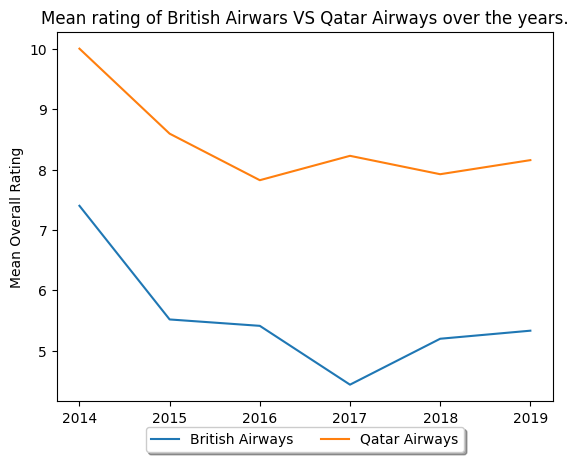

In [21]:
bae_data = airline[airline['airline'].str.contains('British Airways')]
bae_data = bae_data.groupby(bae_data.date_flown.dt.year)['overall'].mean()
bae_data = bae_data.to_frame()
qatar_data = airline[airline['airline'].str.contains('Qatar Airways')]
qatar_data = qatar_data.groupby(qatar_data.date_flown.dt.year)['overall'].mean()
qatar_data = qatar_data.to_frame()

plt.figure()
plt.plot(bae_data.index,bae_data['overall'],label='British Airways')
plt.plot(qatar_data.index,qatar_data['overall'],label='Qatar Airways')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.xlabel('Year')
plt.ylabel('Mean Overall Rating')
plt.title('Mean rating of British Airwars VS Qatar Airways over the years.')
plt.show()

Preparing a dataset copy for K-means clustering analysis.

In [22]:
x_knn_copy = airline.copy()
x_knn_copy.drop(['customer_review', 'aircraft','date_flown','route','airline','Start','seat_comfort','cabin_service','food_bev','entertainment','ground_service','recommended','Verified','month','value_for_money','Destination','Start_long','Start_lat','Destination_long','Destination_lat'], axis=1, inplace=True)
#x_knn_copy.drop(['customer_review', 'aircraft','date_flown','route','airline','Start','Destination','recommended','Verified'], axis=1, inplace=True)

In [23]:
x_knn_copy.dropna(inplace=True)
airline.dropna(inplace=True)

In [24]:
x_knn_copy

,overall,traveller_type,cabin,Transit,aircraft_manu,Season,Start_Country,Destination_Country,miles
0,10.0,Solo Leisure,Economy Class,False,Airbus,Spring,Usa,Pakistan,8925.731443
1,2.0,Solo Leisure,Economy Class,True,Both,Spring,Switzerland,Turkey,5402.602578
2,6.0,Solo Leisure,Economy Class,True,Both,Spring,United Arab Emirates,Turkey,3165.041001
3,1.0,Solo Leisure,Economy Class,True,Airbus,Winter,Italy,Turkey,5402.602578
4,2.0,Solo Leisure,Economy Class,True,Boeing,Spring,Usa,Turkey,13793.888605
...,...,...,...,...,...,...,...,...,...
14205,9.0,Solo Leisure,Economy Class,False,Boeing,Winter,France,Russia,3154.775440
14206,8.0,Family Leisure,Economy Class,True,Both,Autumn,Israel,Russia,1787.583472
14207,6.0,Solo Leisure,Economy Class,True,Boeing,Autumn,Usa,Russia,11661.259887
14208,7.0,Couple Leisure,Economy Class,True,Boeing,Winter,Poland,Russia,1118.743967


Converting categorical data into numerical data.

In [24]:
le = LabelEncoder()
y = x_knn_copy['traveller_type']
z= x_knn_copy['cabin']
x_knn_copy['traveller_type'] = le.fit_transform(x_knn_copy['traveller_type'])
y = le.transform(y)
x_knn_copy['cabin'] = le.fit_transform(x_knn_copy['cabin'])
z = le.transform(z)
p = x_knn_copy['Season']
x_knn_copy['Season'] = le.fit_transform(x_knn_copy['Season'])
p = le.transform(p)
r = x_knn_copy['Start_Country']
x_knn_copy['Start_Country'] = le.fit_transform(x_knn_copy['Start_Country'])
r = le.transform(r)
s = x_knn_copy['Destination_Country']
x_knn_copy['Destination_Country'] = le.fit_transform(x_knn_copy['Destination_Country'])
s = le.transform(s)
x_knn_copy['Transit']=le.fit_transform(x_knn_copy['Transit'])
x_knn_copy['aircraft_manu']=le.fit_transform(x_knn_copy['aircraft_manu'])
#Converting the miles attribute into a normalised form
x_knn_copy['miles'] = x_knn_copy['miles'] /x_knn_copy['miles'].abs().max()
x_knn_copy.head()

,overall,traveller_type,cabin,Transit,aircraft_manu,Season,Start_Country,Destination_Country,miles
0,10.0,3,1,0,0,1,131,88,0.452891
1,2.0,3,1,1,2,1,120,118,0.274128
2,6.0,3,1,1,2,1,129,118,0.160594
3,1.0,3,1,1,0,3,56,118,0.274128
4,2.0,3,1,1,1,1,131,118,0.699902


Example code used to convert the entire dataset into normalised

In [ ]:
x_knn_copy['Start_Country'] = x_knn_copy['Start_Country'] /x_knn_copy['Start_Country'].abs().max()
x_knn_copy['Destination_Country'] = x_knn_copy['Destination_Country'] /x_knn_copy['Destination_Country'].abs().max()
x_knn_copy['overall'] = x_knn_copy['overall'] /x_knn_copy['overall'].abs().max()
x_knn_copy['traveller_type'] = x_knn_copy['traveller_type'] /x_knn_copy['traveller_type'].abs().max()
x_knn_copy['Season'] = x_knn_copy['Season'] /x_knn_copy['Season'].abs().max()

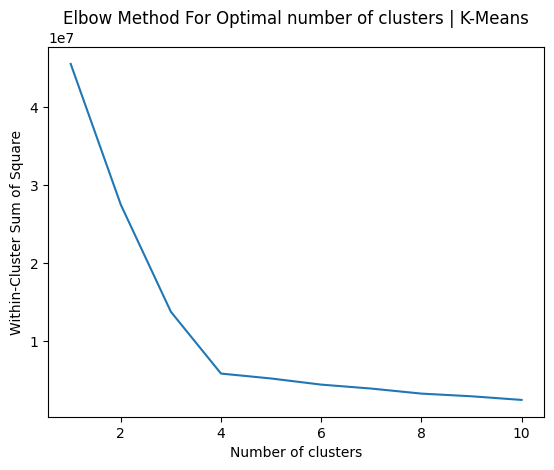

In [26]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 4362, n_init = "auto", random_state = 0)
    kmeans.fit(x_knn_copy)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('Elbow Method For Optimal number of clusters | K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.show()

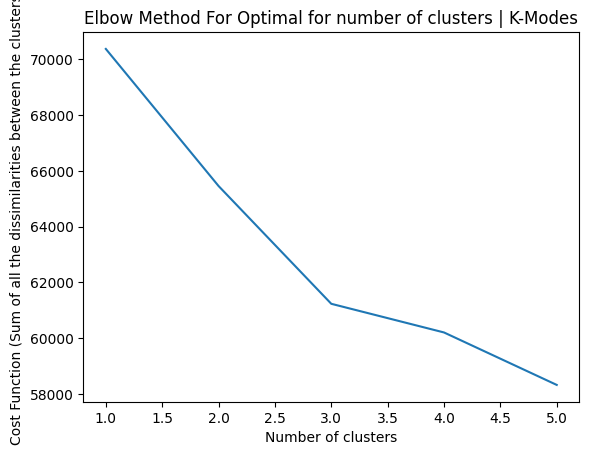

In [ ]:
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(x_knn_copy)
    cost.append(kmode.cost_)

plt.plot(K, cost)
plt.xlabel('Number of clusters')
plt.ylabel('Cost Function (Sum of all the dissimilarities between the clusters)')
plt.title('Elbow Method For Optimal for number of clusters | K-Modes')
plt.show()

In [25]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(x_knn_copy)
labels = kmeans.labels_
labels = kmeans.predict(x_knn_copy)
s = metrics.silhouette_score(x_knn_copy, labels, metric='euclidean')
print(f'Silhouette Coefficient of kmeans clustering on the passengers: {s:.2f}')
cent = kmeans.cluster_centers_
kmeans = pd.DataFrame(labels)
airline.insert((x_knn_copy.shape[1]),'kmeans',kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Coefficient of kmeans clustering on the passengers: 0.61


In [ ]:
def create_dm(dataset):
    #if the input dataset is a dataframe, we take out the values as a numpy.
    #If the input dataset is a numpy array, we use it as is.
    if type(dataset).__name__=='DataFrame':
        dataset=dataset.values
    lenDataset=len(dataset)
    distance_matrix=np.zeros(lenDataset*lenDataset).reshape(lenDataset,lenDataset)
    for i in range(lenDataset):
        for j in range(lenDataset):
            x1= dataset[i].reshape(1,-1)
            x2= dataset[j].reshape(1,-1)
            distance=kprototypes.matching_dissim(x1, x2)
            distance_matrix[i][j]=distance
            distance_matrix[j][i]=distance
    return distance_matrix

In [ ]:
km_huang = KModes(n_clusters=3, init = "Huang", n_init = 5, verbose=0)
clusters_huang = km_huang.fit_predict(x_knn_copy)
distance_matrix = create_dm(x_knn_copy)
s = metrics.silhouette_score(distance_matrix, clusters_huang ,metric="precomputed")
print(f'Silhouette Coefficient of kmodes clustering on the passengers: {s:.2f}')

Silhouette Coefficient of kmodes clustering on the passengers: 0.08


k-means on british airways.

In [28]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,kmeans,...,aircraft_manu,month,Season,Start_Country,Start_long,Start_lat,Destination_Country,Destination_long,Destination_lat,miles
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,3.0,...,Airbus,4,Spring,Usa,-77.456,38.944,Pakistan,0.000,0.000,8925.731443
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,Both,4,Spring,Switzerland,0.000,0.000,Turkey,28.821,40.977,5402.602578
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,Both,4,Spring,United Arab Emirates,54.651,24.433,Turkey,28.821,40.977,3165.041001
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,0.0,...,Airbus,2,Winter,Italy,0.000,0.000,Turkey,28.821,40.977,5402.602578
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,Boeing,3,Spring,Usa,-95.340,29.980,Turkey,28.821,40.977,13793.888605


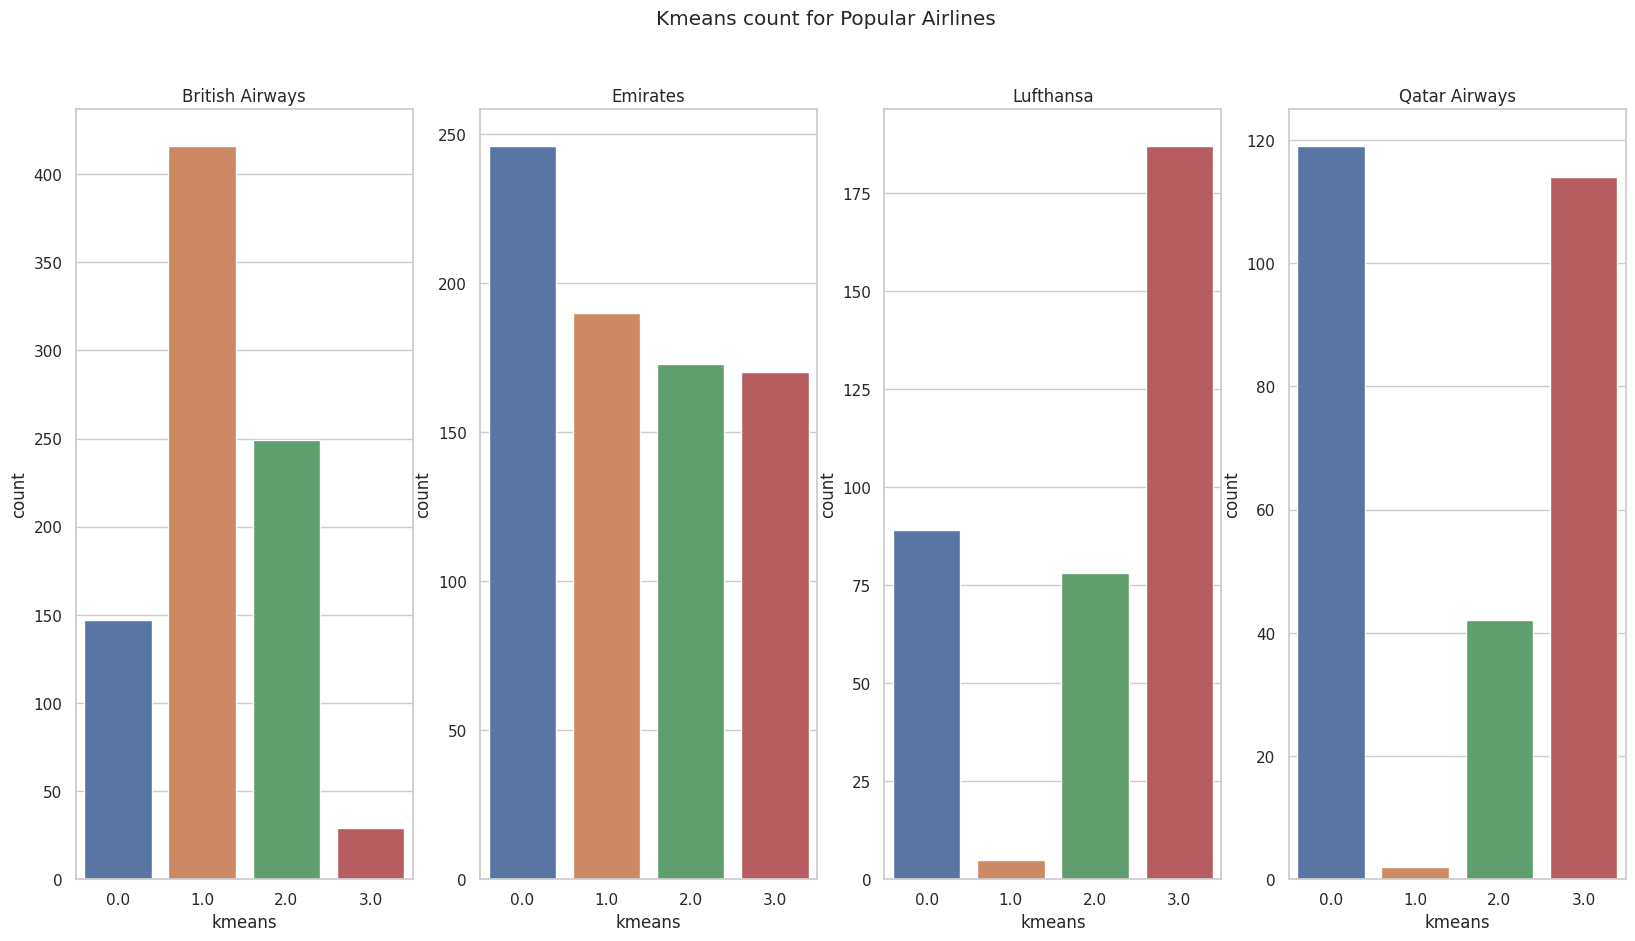

In [ ]:
import seaborn as sns
selected_airlines = airline[airline['airline'].isin(['Qatar Airways', 'Emirates', 'Lufthansa','British Airways'])]
#resetting the index of the dataset
selected_airlines.reset_index(drop = True, inplace=True)
#dropping features we are not interested in.


selected_airlines = selected_airlines.drop(['overall','customer_review','aircraft','traveller_type','cabin','route','date_flown','seat_comfort','cabin_service','food_bev','entertainment','ground_service','value_for_money','Verified','Start','Destination','aircraft_manu','Transit','Season','month','Start_long','Start_lat','Destination_long','Destination_lat','miles','recommended','Start_Country','Destination_Country'], axis=1)
total = selected_airlines.value_counts().values.sum()

def fmt(x):
    return '{:.1f}%'.format(x)

fig, axes = plt.subplots(1,4, figsize=(20, 10))
fig.suptitle('Kmeans count for Popular Airlines')
i = 0
for group_name, group_data in selected_airlines.groupby('airline'):
    sns.countplot(x=group_data['kmeans'],ax = axes[i])
    axes[i].set_title(group_name)
    i = i+ 1

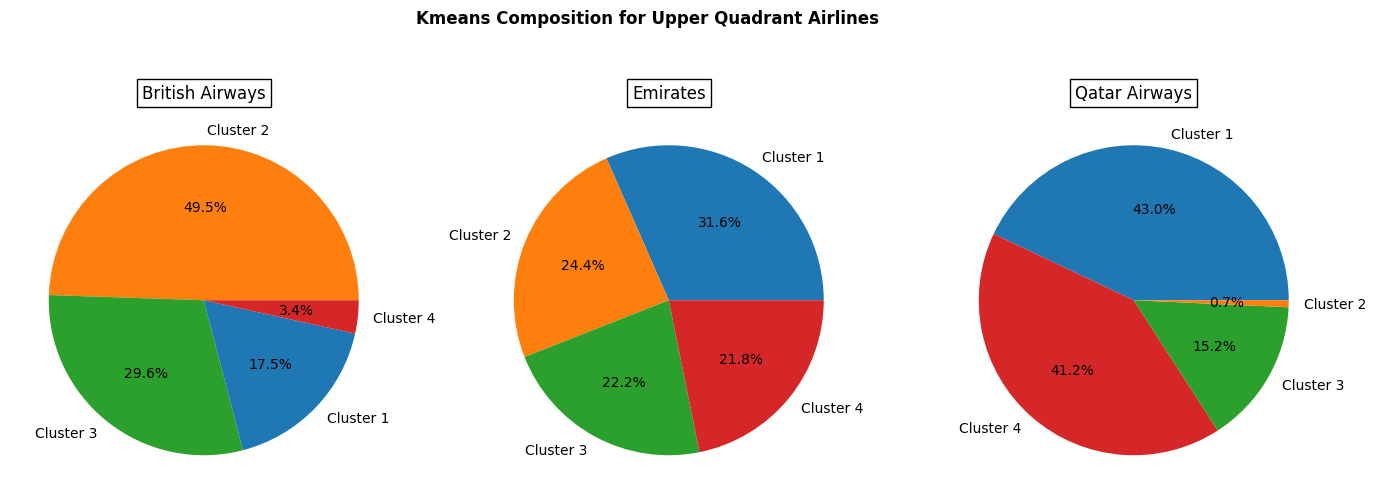

In [26]:
selected_airlines = airline[airline['airline'].isin(['Qatar Airways', 'Emirates','British Airways'])]
#resetting the index of the dataset
selected_airlines.reset_index(drop = True, inplace=True)
selected_airlines = selected_airlines.drop(['overall','customer_review','aircraft','traveller_type','cabin','route','date_flown','seat_comfort','cabin_service','food_bev','entertainment','ground_service','value_for_money','Verified','Start','Destination','aircraft_manu','Transit','Season','month','Start_long','Start_lat','Destination_long','Destination_lat','miles','recommended','Start_Country','Destination_Country'], axis=1)
selected_airlines.sort_values(by=['kmeans'], ascending=False, inplace=True)
total = selected_airlines.value_counts().values.sum()
colours = {0.0: 'C0',
           1.0: 'C1',
           2.0: 'C2',
           3.0: 'C3'}
label_in_writing = {0.0: 'Cluster 1',
           1.0: 'Cluster 2',
           2.0: 'Cluster 3',
           3.0: 'Cluster 4'}
def fmt(x):
    return '{:.1f}%'.format(x)

fig, axes = plt.subplots(1,3, figsize=(17, 6))
fig.suptitle('Kmeans Composition for Upper Quadrant Airlines', fontweight ="bold")
i = 0
for group_name, group_data in selected_airlines.groupby('airline'):
    #sns.countplot(x=group_data['kmeans'],ax = axes[i])
    labels = group_data['kmeans'].value_counts().index
    axes[i].pie(group_data['kmeans'].value_counts().values, labels=[label_in_writing[key] for key in labels], autopct=fmt, colors=[colours[key] for key in labels])
    axes[i].set_title(group_name,   bbox=dict(boxstyle = "square",
                  facecolor = "white"))
    i = i+ 1


In [ ]:
plt.figure()
plt.pie(airline['kmeans'].value_counts().values, labels=[label_in_writing[key] for key in labels], autopct=fmt, colors=[colours[key] for key in labels])

Plotting the dataset in a geographical space.

<ipython-input-39-4a9c3448536a>:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


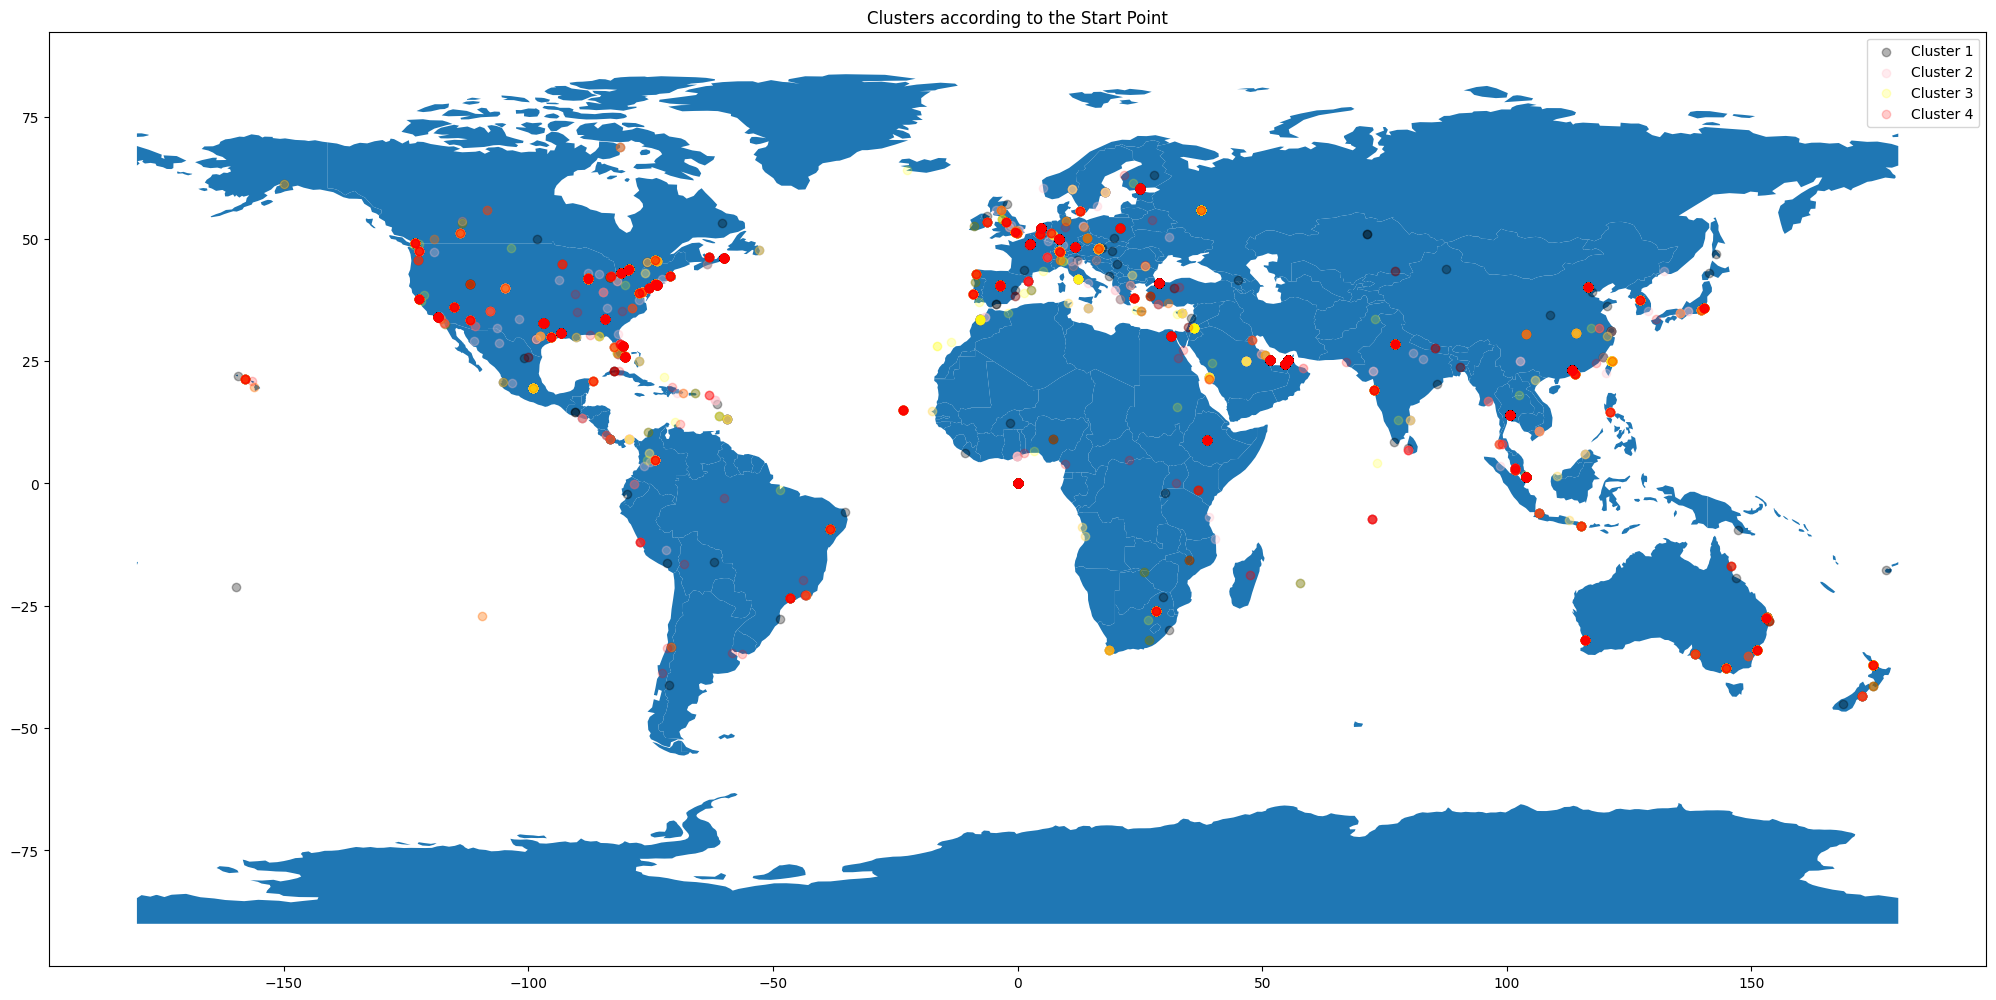

In [39]:
import geopandas as gpd
import pandas as pd


airline_geo = gpd.GeoDataFrame(airline, geometry = gpd.points_from_xy(airline.Destination_long, airline.Destination_lat))
kmeans_1_airline = airline_geo[airline_geo['kmeans']==0]
kmeans_2_airline = airline_geo[airline_geo['kmeans']==1]
kmeans_3_airline = airline_geo[airline_geo['kmeans']==2]
kmeans_4_airline = airline_geo[airline_geo['kmeans']==3]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

axis = world.plot()
kmeans_1_airline.plot(ax = axis, color='black',alpha=0.3, label = 'Cluster 1')
kmeans_2_airline.plot(ax = axis, color='pink',alpha=0.3, label = 'Cluster 2')
kmeans_3_airline.plot(ax = axis, color='yellow',alpha=0.2, label = 'Cluster 3')
kmeans_4_airline.plot(ax = axis, color='red',alpha=0.2, label = 'Cluster 4')

fig = plt.gcf()
fig.set_size_inches(25,25)
plt.title('Clusters according to the Start Point')
plt.legend()
plt.show()

In [1]:
import geopandas as gpd
import pandas as pd


airline_geo = gpd.GeoDataFrame(airline, geometry = gpd.points_from_xy(airline.Destination_long, airline.Destination_lat))
airline_geo_ST = gpd.GeoDataFrame(airline, geometry = gpd.points_from_xy(airline.Start_long, airline.Start_lat))
kmeans_1_airline = airline_geo[airline_geo['kmeans']==0]
kmeans_2_airline = airline_geo[airline_geo['kmeans']==1]
kmeans_3_airline = airline_geo[airline_geo['kmeans']==2]
kmeans_4_airline = airline_geo[airline_geo['kmeans']==3]
kmeans_1_airline_ST = airline_geo_ST[airline_geo_ST['kmeans']==0]
kmeans_2_airline_ST = airline_geo_ST[airline_geo_ST['kmeans']==1]
kmeans_3_airline_ST = airline_geo_ST[airline_geo_ST['kmeans']==2]
kmeans_4_airline_ST = airline_geo_ST[airline_geo_ST['kmeans']==3]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

axis = world.plot(airline_geo,airline_geo_ST)
axis.plot()

fig = plt.gcf()
fig.set_size_inches(25,25)
plt.title('Clusters according to the Start Point')
plt.legend()
plt.show()

NameError: ignored

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
<ipython-input-40-319714e4ca28>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


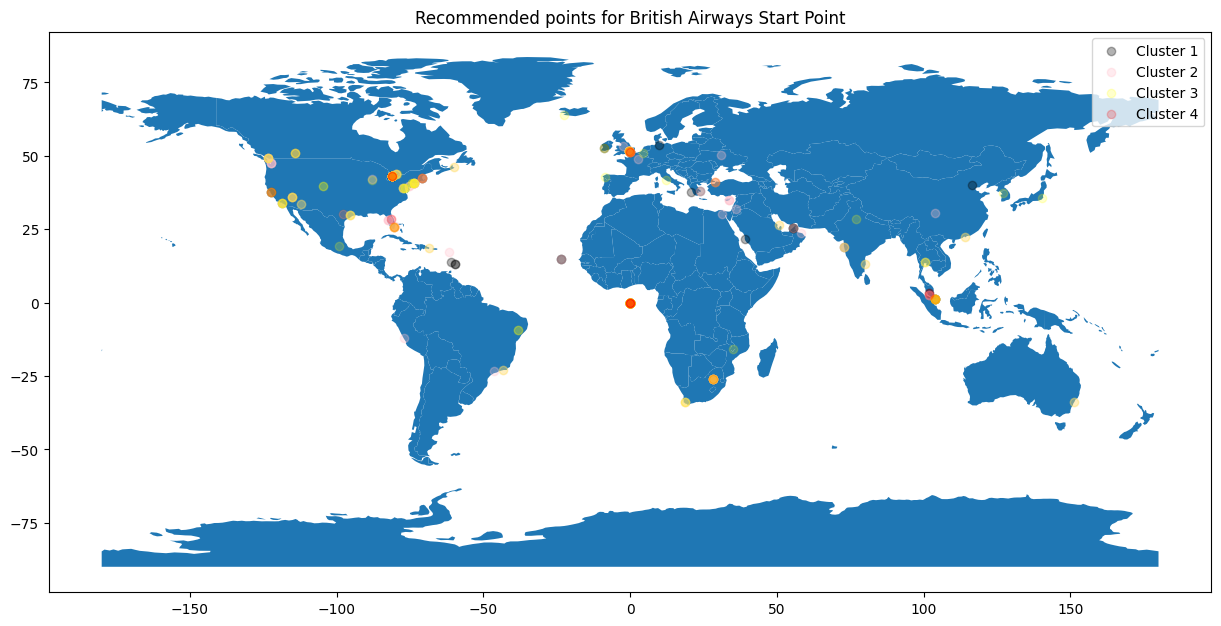

In [40]:
bae_geo = airline_geo[airline_geo['airline'].str.contains('British Airways')]
bae_geo = bae_geo[bae_geo['recommended'].str.contains('yes')]
kmeans1_airline = bae_geo[airline_geo['kmeans']==0]
kmeans2_airline = bae_geo[airline_geo['kmeans']==1]
kmeans3_airline = bae_geo[airline_geo['kmeans']==2]
kmeans4_airline = bae_geo[airline_geo['kmeans']==3]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

axis = world.plot()
kmeans1_airline.plot(ax = axis, color='black',alpha=0.3, label = 'Cluster 1')
kmeans2_airline.plot(ax = axis, color='pink',alpha=0.3, label = 'Cluster 2')
kmeans3_airline.plot(ax = axis, color='yellow',alpha=0.2, label = 'Cluster 3')
kmeans4_airline.plot(ax = axis, color='red',alpha=0.2, label = 'Cluster 4')

fig = plt.gcf()
fig.set_size_inches(15,15)
plt.legend()
plt.title('Recommended points for British Airways Start Point')
plt.show()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
<ipython-input-41-cac821f36a81>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


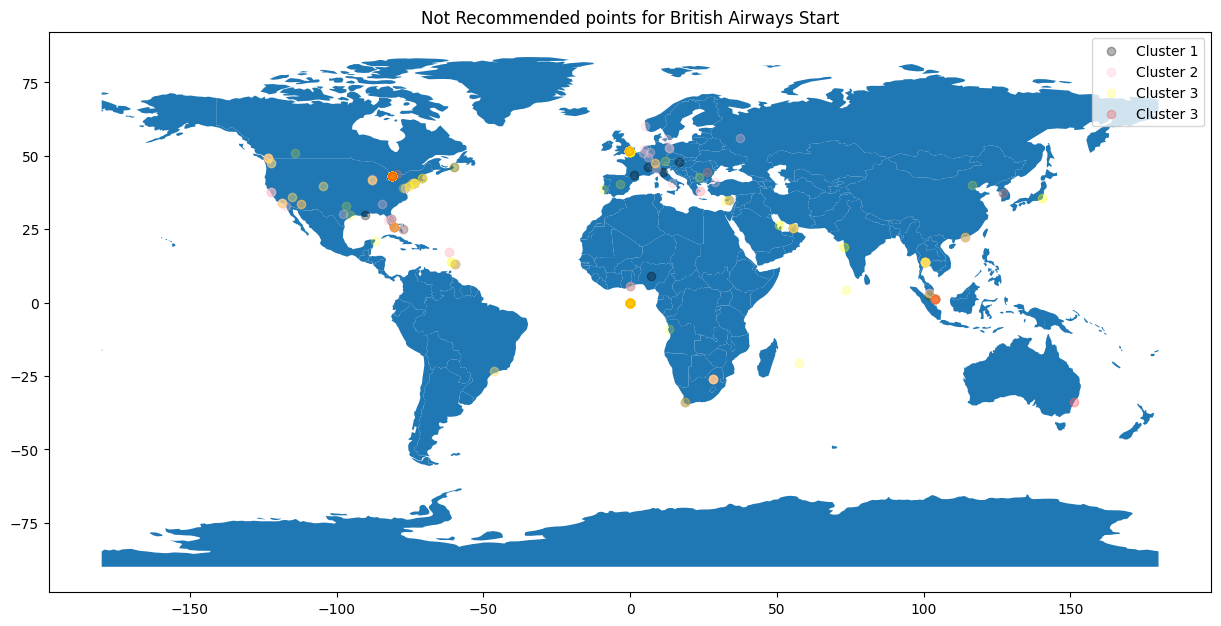

In [41]:
bae_geo = airline_geo[airline_geo['airline'].str.contains('British Airways')]
bae_geo = bae_geo[bae_geo['recommended'].str.contains('no')]
kmeans1_airline = bae_geo[airline_geo['kmeans']==0]
kmeans2_airline = bae_geo[airline_geo['kmeans']==1]
kmeans3_airline = bae_geo[airline_geo['kmeans']==2]
kmeans4_airline = bae_geo[airline_geo['kmeans']==3]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

axis = world.plot()
kmeans1_airline.plot(ax = axis, color='black',alpha=0.3, label = 'Cluster 1')
kmeans2_airline.plot(ax = axis, color='pink',alpha=0.3, label = 'Cluster 2')
kmeans3_airline.plot(ax = axis, color='yellow',alpha=0.2, label = 'Cluster 3')
kmeans4_airline.plot(ax = axis, color='red',alpha=0.2, label = 'Cluster 3')

fig = plt.gcf()
fig.set_size_inches(15,15)
plt.legend()
plt.title('Not Recommended points for British Airways Start')
plt.show()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
<ipython-input-34-fa6a70cb72d4>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


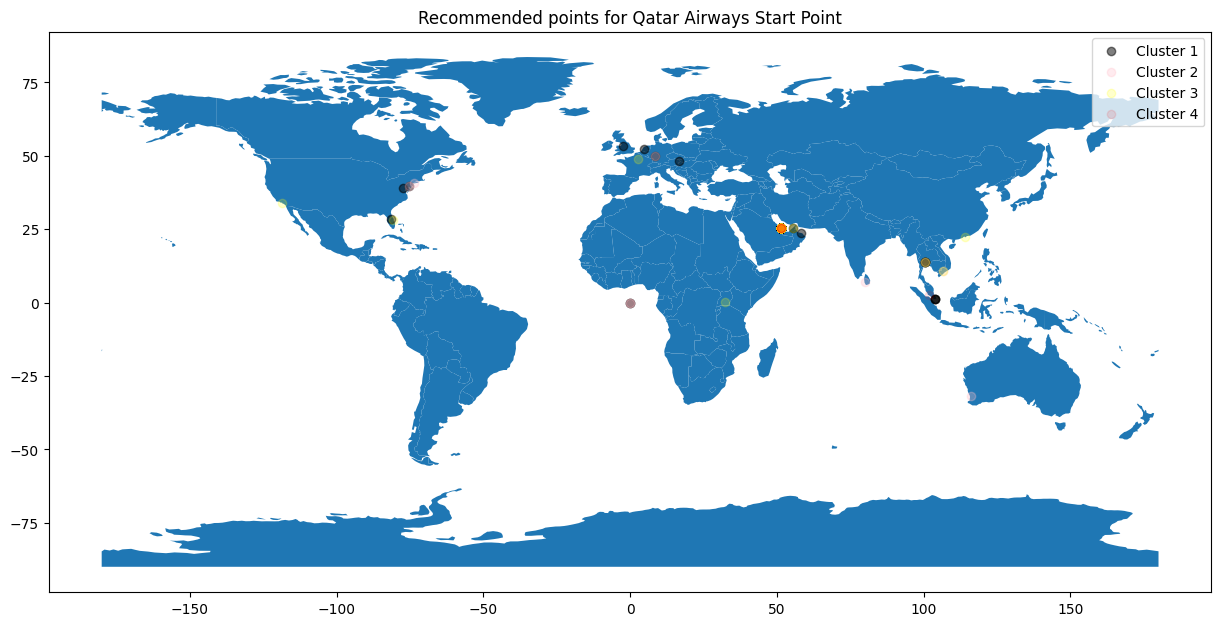

In [ ]:
bae_geo = airline_geo[airline_geo['airline'].str.contains('Qatar Airways')]
bae_geo = bae_geo[bae_geo['recommended'].str.contains('yes')]
kmeans1_airline = bae_geo[airline_geo['kmeans']==0]
kmeans2_airline = bae_geo[airline_geo['kmeans']==1]
kmeans3_airline = bae_geo[airline_geo['kmeans']==2]
kmeans4_airline = bae_geo[airline_geo['kmeans']==3]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

axis = world.plot()
kmeans1_airline.plot(ax = axis, color='black',alpha=0.5, label = 'Cluster 1')
kmeans2_airline.plot(ax = axis, color='pink',alpha=0.3, label = 'Cluster 2')
kmeans3_airline.plot(ax = axis, color='yellow',alpha=0.2, label = 'Cluster 3')
kmeans4_airline.plot(ax = axis, color='red',alpha=0.1, label = 'Cluster 4')

fig = plt.gcf()
fig.set_size_inches(15,15)
plt.legend()
plt.title('Recommended points for Qatar Airways Start Point')
plt.show()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1475: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
<ipython-input-41-dfc57991a462>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


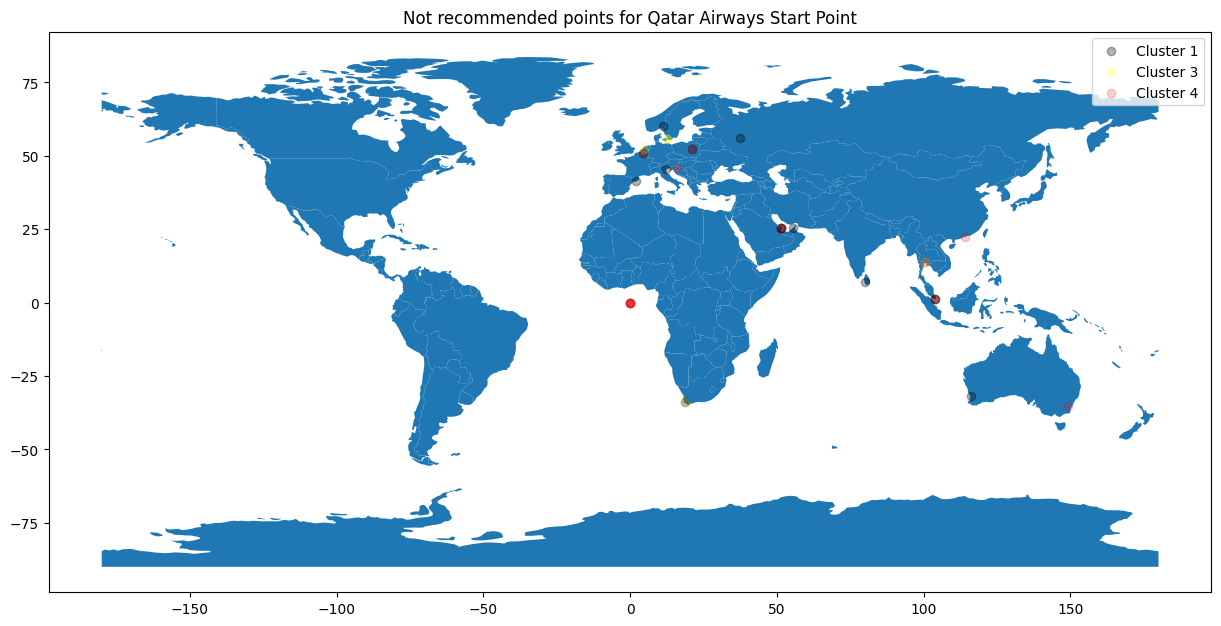

In [ ]:
bae_geo = airline_geo[airline_geo['airline'].str.contains('Qatar Airways')]
bae_geo = bae_geo[bae_geo['recommended'].str.contains('no')]
kmeans1_airline = bae_geo[airline_geo['kmeans']==0]
kmeans2_airline = bae_geo[airline_geo['kmeans']==1]
kmeans3_airline = bae_geo[airline_geo['kmeans']==2]
kmeans4_airline = bae_geo[airline_geo['kmeans']==3]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot()

axis = world.plot()
kmeans1_airline.plot(ax = axis, color='black',alpha=0.3, label = 'Cluster 1')
kmeans2_airline.plot(ax = axis, color='pink',alpha=0.3, label = 'Cluster 2')
kmeans3_airline.plot(ax = axis, color='yellow',alpha=0.2, label = 'Cluster 3')
kmeans4_airline.plot(ax = axis, color='red',alpha=0.2, label = 'Cluster 4')

fig = plt.gcf()
fig.set_size_inches(15,15)
plt.legend()
plt.title('Not recommended points for Qatar Airways Start Point')
plt.show()

In [42]:
#'customer_review', 'aircraft','date_flown','route','airline','Start','seat_comfort','cabin_service','food_bev','entertainment','ground_service','recommended','Verified','month','overall','value_for_money','Destination'
airline['miles'] = airline['miles'] /airline['miles'].abs().max()
bae_data = airline[airline['airline'].str.contains('British Airways')]
ratings = airline.groupby(["kmeans"]).agg(
    seat_comfort_mean = ("seat_comfort", "mean"),
    cabin_mean = ("cabin_service", "mean"),
    food_bev_mean = ("food_bev", "mean"),
    entertainment_mean = ("entertainment", "mean"),
    ground_service_mean = ("ground_service", "mean"),
    value_for_money_mean = ("value_for_money", "mean"),
    miles = ("miles", "mean")
).reset_index()
ratings['miles'] = ratings['miles'].apply(lambda x: x*10)

In [43]:
ratings.head()

,kmeans,seat_comfort_mean,cabin_mean,food_bev_mean,entertainment_mean,ground_service_mean,value_for_money_mean,miles
0,0.0,3.488809,3.748736,3.325632,3.401805,3.456679,3.575090,3.729769
1,1.0,3.448728,3.706280,3.297695,3.300874,3.489269,3.489666,3.741178
2,2.0,3.458566,3.700186,3.307728,3.320764,3.466946,3.540968,3.858150
3,3.0,3.437388,3.681574,3.324240,3.383721,3.375224,3.506708,3.691846


In [44]:
ratings.drop('kmeans',axis=1,inplace=True)
ratings_T = ratings.transpose()
ratings_T.rename(columns={0: "K_zero", 1: "K_one",2:"K_two",3:"K_three"})

,K_zero,K_one,K_two,K_three
seat_comfort_mean,3.488809,3.448728,3.458566,3.437388
cabin_mean,3.748736,3.706280,3.700186,3.681574
food_bev_mean,3.325632,3.297695,3.307728,3.324240
entertainment_mean,3.401805,3.300874,3.320764,3.383721
ground_service_mean,3.456679,3.489269,3.466946,3.375224
value_for_money_mean,3.575090,3.489666,3.540968,3.506708
miles,3.729769,3.741178,3.858150,3.691846


In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap


# Values for the x axis
ANGLES = np.linspace(0.05, 2 * np.pi - 0.05, len(ratings_T), endpoint=False)

# Cumulative length
kmeans_0 = ratings_T.iloc[:, 0].to_numpy()
kmeans_1 = ratings_T.iloc[:, 1].to_numpy()
kmeans_2 = ratings_T.iloc[:, 2].to_numpy()
kmeans_3 = ratings_T.iloc[:, 3].to_numpy()

# Region label
mean_ratings = ratings_T.index.to_numpy()


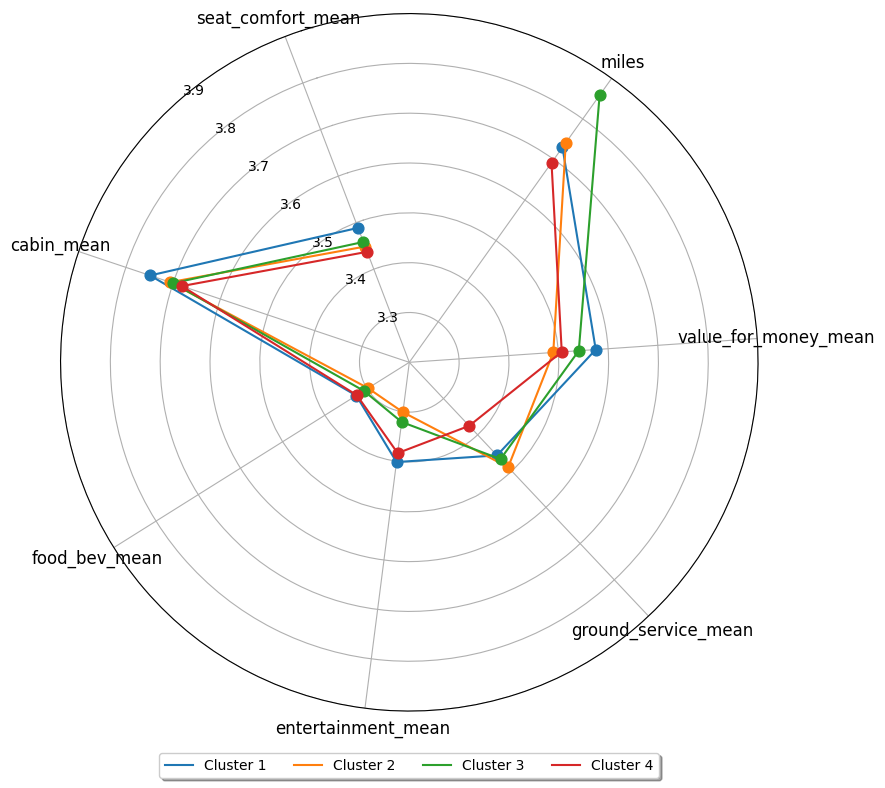

In [47]:
# Some layout stuff ----------------------------------------------
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(1.2 * np.pi / 2)
ax.set_ylim(3.2, 3.9)
# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top


# Add dots to represent the mean gain
ax.scatter(ANGLES, kmeans_0, s=60, zorder=11, color = 'C0')
ax.plot(ANGLES, kmeans_0, zorder=11, label = "Cluster 1", color = 'C0')
ax.scatter(ANGLES, kmeans_1, s=60, zorder=11, color = 'C1')
ax.plot(ANGLES, kmeans_1, zorder=11, label = "Cluster 2", color = 'C1')
ax.scatter(ANGLES, kmeans_2, s=60, zorder=11, color = 'C2')
ax.plot(ANGLES, kmeans_2, zorder=11, label = "Cluster 3", color = 'C2')
ax.scatter(ANGLES, kmeans_3, s=60, zorder=11, color = 'C3')
ax.plot(ANGLES, kmeans_3, zorder=11, label = "Cluster 4", color = 'C3')

# Add labels for the regions -------------------------------------
# Note the 'wrap()' function.
# The '5' means we want at most 5 consecutive letters in a word,
# but the 'break_long_words' means we don't want to break words
# longer than 5 characters.
REGION = ["\n".join(wrap(r, 5, break_long_words=False)) for r in mean_ratings]

# Set the labels
ax.set_xticks(ANGLES)
ax.set_xticklabels(REGION, rotation=100, size=12);
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

<ipython-input-48-375f0594957c>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  british_a_bar = british_a_bar.groupby(['kmeans','recommended']).mean()


<Figure size 640x480 with 0 Axes>

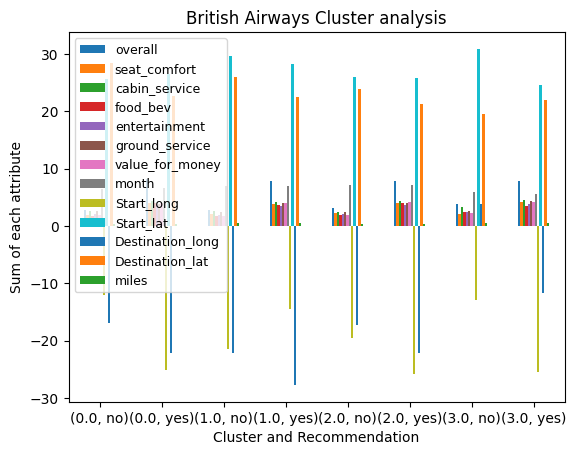

In [ ]:
british_airways = airline[airline['airline'].str.contains('British')]
british_a_bar = british_airways.copy()
british_a_bar.drop('Verified',axis=1, inplace=True)
british_airways_cluster_1 = british_a_bar[british_a_bar['kmeans']==0]
british_airways_cluster_2 = british_a_bar[british_a_bar['kmeans']==1]
british_airways_cluster_1

plt.figure()
british_a_bar = british_a_bar.groupby(['kmeans','recommended']).mean()
british_a_bar.plot.bar()
plt.xlabel('Cluster and Recommendation')
plt.ylabel('Sum of each attribute')
plt.xticks(rotation ='horizontal')
plt.title('British Airways Cluster analysis')
plt.legend(fontsize="9",loc='upper left')
plt.show()


# Density Based Clustering


```
# This is formatted as code
```



In [ ]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,aircraft_manu,month,Season,Start_Country,Start_long,Start_lat,Destination_Country,Destination_long,Destination_lat,miles
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,...,Airbus,4,Spring,Usa,-77.456,38.944,Pakistan,0.000,0.000,8925.731443
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,Both,4,Spring,Switzerland,0.000,0.000,Turkey,28.821,40.977,5402.602578
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,Both,4,Spring,United Arab Emirates,54.651,24.433,Turkey,28.821,40.977,3165.041001
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,...,Airbus,2,Winter,Italy,0.000,0.000,Turkey,28.821,40.977,5402.602578
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,Boeing,3,Spring,Usa,-95.340,29.980,Turkey,28.821,40.977,13793.888605


In [ ]:
y_dbscan_copy = airline.copy()
y_dbscan_copy.drop(['customer_review', 'aircraft','date_flown','route','airline','Start','seat_comfort','cabin_service','food_bev','entertainment','ground_service','recommended','Verified','month','overall','value_for_money','Destination'], axis=1, inplace=True)

In [ ]:
y_dbscan_copy.head()

,traveller_type,cabin,kmeans,Transit,aircraft_manu,Season,Start_Country,Destination_Country
0,Solo Leisure,Economy Class,0,False,Airbus,Spring,Usa,Pakistan
1,Solo Leisure,Economy Class,0,True,Both,Spring,Switzerland,Turkey
2,Solo Leisure,Economy Class,0,True,Both,Spring,United Arab Emirates,Turkey
3,Solo Leisure,Economy Class,2,True,Airbus,Winter,Italy,Turkey
4,Solo Leisure,Economy Class,0,True,Boeing,Spring,Usa,Turkey


In [ ]:
le = LabelEncoder()
y = y_dbscan_copy['traveller_type']
z= y_dbscan_copy['cabin']
y_dbscan_copy['traveller_type'] = le.fit_transform(y_dbscan_copy['traveller_type'])
y = le.transform(y)
y_dbscan_copy['cabin'] = le.fit_transform(y_dbscan_copy['cabin'])
z = le.transform(z)
p = y_dbscan_copy['Season']
y_dbscan_copy['Season'] = le.fit_transform(y_dbscan_copy['Season'])
p = le.transform(p)
r = y_dbscan_copy['Start_Country']
y_dbscan_copy['Start_Country'] = le.fit_transform(y_dbscan_copy['Start_Country'])
r = le.transform(r)
s = y_dbscan_copy['Destination_Country']
y_dbscan_copy['Destination_Country'] = le.fit_transform(y_dbscan_copy['Destination_Country'])
s = le.transform(s)
y_dbscan_copy['Transit']=le.fit_transform(y_dbscan_copy['Transit'])
y_dbscan_copy['aircraft_manu']=le.fit_transform(y_dbscan_copy['aircraft_manu'])
y_dbscan_copy.head()

,traveller_type,cabin,kmeans,Transit,aircraft_manu,Season,Start_Country,Destination_Country
0,3,1,0,0,0,1,146,96
1,3,1,0,1,2,1,133,127
2,3,1,0,1,2,1,142,127
3,3,1,2,1,0,3,65,127
4,3,1,0,1,1,1,146,127


In [ ]:
epsilons = np.linspace(0.01, 1, num=15)
min_samples = np.arange(10, 100, step=3)
import itertools

combinations = list(itertools.product(epsilons, min_samples))

In [ ]:
from sklearn.metrics import silhouette_score as ss
N= len(combinations)
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue

    scores.append(ss(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, y_dbscan_copy)

Index: 0, Score: 0.03170369428702183, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 13
Index: 1, Score: 0.022191521531300773, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 7
Index: 2, Score: 0.015874965042680902, Labels: [-1 -1 -1 ... -1 -1 -1], NumClusters: 4
Combination (0.01, 19) on iteration 4 of 450 has 1 clusters. Moving on
Combination (0.01, 22) on iteration 5 of 450 has 0 clusters. Moving on
Combination (0.01, 25) on iteration 6 of 450 has 0 clusters. Moving on
Combination (0.01, 28) on iteration 7 of 450 has 0 clusters. Moving on
Combination (0.01, 31) on iteration 8 of 450 has 0 clusters. Moving on
Combination (0.01, 34) on iteration 9 of 450 has 0 clusters. Moving on
Combination (0.01, 37) on iteration 10 of 450 has 0 clusters. Moving on
Combination (0.01, 40) on iteration 11 of 450 has 0 clusters. Moving on
Combination (0.01, 43) on iteration 12 of 450 has 0 clusters. Moving on
Combination (0.01, 46) on iteration 13 of 450 has 0 clusters. Moving on
Combination (0.01, 49) on

In [ ]:
best_dict

{'best_epsilon': 0.01,
 'best_min_samples': 10,
 'best_labels': array([-1, -1, -1, ..., -1, -1, -1]),
 'best_score': 0.03170369428702183}

In [ ]:
airline['dbscan'] = best_dict['best_labels']

airline['dbscan'].value_counts()

-1     14034
 6        20
 8        18
 3        17
 2        16
 4        15
 9        14
 10       14
 7        12
 1        11
 5        11
 0        10
 11       10
 12       10
Name: dbscan, dtype: int64

In [ ]:
airline.head()

,airline,overall,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,...,entertainment,ground_service,kmeans,value_for_money,recommended,Verified,Start,Transit,Destination,aircraft_manu
0,Turkish Airlines,10.0,Flew on Turkish Airlines IAD-IST-KHI and retu...,A330,Solo Leisure,Economy Class,Washington Dulles to Karachi,2019-04-01,4.0,5.0,...,5.0,5.0,1,5.0,yes,True,Washington Dulles,False,Karachi,Airbus
1,Turkish Airlines,2.0,Basel to Cape Town via Istanbul. When I arriv...,Boeing 737-800 / A330-300,Solo Leisure,Economy Class,Basel to Cape Town via Istanbul,2019-04-01,3.0,3.0,...,3.0,1.0,0,2.0,no,True,Basel,True,Istanbul,Both
2,Turkish Airlines,6.0,Abu Dhabi to Luxembourg via Istanbul. From AU...,A320 / Boeing 737,Solo Leisure,Economy Class,Abu Dhabi to Luxembourg via Istanbul,2019-04-01,2.0,3.0,...,3.0,3.0,0,3.0,yes,False,Abu Dhabi,True,Istanbul,Both
3,Turkish Airlines,1.0,The experience with Turkish Airlines has been...,A320 / A330,Solo Leisure,Economy Class,Venice to Boston via Istanbul,2019-02-01,1.0,1.0,...,1.0,1.0,0,1.0,no,True,Venice,True,Istanbul,Airbus
4,Turkish Airlines,2.0,Houston to Kiev via Istanbul. Fares seem comp...,Boeing 777-300,Solo Leisure,Economy Class,Houston to Kiev via Istanbul,2019-03-01,1.0,3.0,...,2.0,1.0,0,1.0,no,True,Houston,True,Istanbul,Boeing


In [ ]:
!apt install proj-bin libproj-dev libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.9.1-1~focal0).
libproj-dev is already the newest version (7.2.1-1~focal0).
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 170 kB of archives.
After this operation, 485 kB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal/main amd64 proj-bin amd64 7.2.1-1~focal0 [170 kB]
Fetched 170 kB in 0s (345 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 122542 files and directories currently installed.)
Preparing to unpack .../proj-bin_7.2.1-1~focal0_amd64.deb ...
Unpacking proj-bin (7.2.1-1~focal0) ...
Setting up proj-bin (7.2.1-1~focal0) ...
Processing triggers for man-db (2.9.1-1) ...


### **Reviews Analysis**




In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
ba_reviews.head()

,Verified,Reviews,Recommended
0,yes,i was flying to warsaw for one day of mee...,no
1,yes,"booked a ba holiday to marrakech, after p...",yes
2,yes,extremely sub-par service. highlights: no ...,no
3,yes,i virtually gave up on british airways ab...,yes
4,yes,i was pleasantly surprised that the airli...,yes


In [ ]:
x = airline['customer_review']

recommendation_mapping = {
           'yes': 1,
           'no': 0}

y = airline['recommended'].map(recommendation_mapping)

#y = pd.get_dummies(airline["recommended"])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.20)

In [ ]:
X_train[0]

' Flew on Turkish Airlines IAD-IST-KHI and return KHI-IST-IAD. Turkish Airlines has consistently maintained its quality since I first flew with them in 2007. The flights leave on time, the catering is excellent, the inflight entertainment is extensive and the interface easy to use, and the cabin crew is excellent. Interesting though the A330 on the KHI-IST route and return seemed to have more leg room and was newer than the A330 on the IAD-IST route which was showing its age. The A330 on the IAD-IST route had a slow responding interface for the inflight entertainment and a broken table on the return flight. But Turkish Airlines will be replacing the A330 on its flight to IAD with the 787 sometime in the summer. Turkish food was served on the return leg which I personally like, and I saw the cabin staff helping elderly passengers walk to the lavatory which was nice. Overall another wonderful experience with Turkish Airlines.'

In [ ]:
Y_train[0]

1

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 1000, lower = True)
tokenizer.fit_on_texts(X_train)

#Convert words into a sequence of numbers in the training set
X_train = tokenizer.texts_to_sequences(X_train)
#Convert words into a sequence of numbers in the testing set
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
print(X_train[0])

[54, 330, 3, 130, 50, 8, 1, 10, 6, 369, 182, 1, 32, 4, 738, 2, 1, 68, 289, 135, 1, 354, 23, 95, 8, 1, 415, 14, 108, 738, 6, 774, 17, 36, 3, 908]


In [ ]:
from keras.utils import pad_sequences

maxlen = 200
X_train = pad_sequences(X_train,padding = 'post',maxlen= maxlen)
X_test = pad_sequences(X_test,padding = 'post',maxlen= maxlen)

In [ ]:
from keras.utils import to_categorical
num_classes = 2
y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

In [ ]:
X_train[0]

array([ 54, 330,   3, 130,  50,   8,   1,  10,   6, 369, 182,   1,  32,
         4, 738,   2,   1,  68, 289, 135,   1, 354,  23,  95,   8,   1,
       415,  14, 108, 738,   6, 774,  17,  36,   3, 908,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN
from keras import optimizers
from keras.utils import pad_sequences
import numpy as np

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

print(X_train.shape)
print(X_test.shape)


(9313, 200, 1)
(2329, 200, 1)


In [ ]:
num_classes = 2

def vanilla_rnn():
  model = Sequential()
  model.add(SimpleRNN(50,input_shape=(maxlen,1),return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('Softmax'))
  model.summary()

  adam = optimizers.Adam(learning_rate=0.0001)
  model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
  return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn= vanilla_rnn,epochs = 20, batch_size=50)
history = model.fit(X_train,y_train,validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 2,702
Trainable params: 2,702
Non-trainable params: 0
_________________________________________________________________


<ipython-input-73-6944a837b9aa>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= vanilla_rnn,epochs = 20, batch_size=50)


Epoch 1/20
187/187 [==============================] - 32s 148ms/step - loss: 0.7195 - accuracy: 0.6230 - val_loss: 0.6356 - val_accuracy: 0.6578
Epoch 2/20
187/187 [==============================] - 26s 139ms/step - loss: 0.6951 - accuracy: 0.6515 - val_loss: 0.6227 - val_accuracy: 0.6587
Epoch 3/20
187/187 [==============================] - 25s 134ms/step - loss: 0.6971 - accuracy: 0.6449 - val_loss: 0.6210 - val_accuracy: 0.6638
Epoch 4/20
187/187 [==============================] - 25s 133ms/step - loss: 0.6795 - accuracy: 0.6536 - val_loss: 0.6191 - val_accuracy: 0.6655
Epoch 5/20
187/187 [==============================] - 26s 139ms/step - loss: 0.6770 - accuracy: 0.6527 - val_loss: 0.6204 - val_accuracy: 0.6638
Epoch 6/20
187/187 [==============================] - 26s 140ms/step - loss: 0.6678 - accuracy: 0.6564 - val_loss: 0.6200 - val_accuracy: 0.6642
Epoch 7/20
187/187 [==============================] - 26s 137ms/step - loss: 0.6722 - accuracy: 0.6559 - val_loss: 0.6151 - val_ac

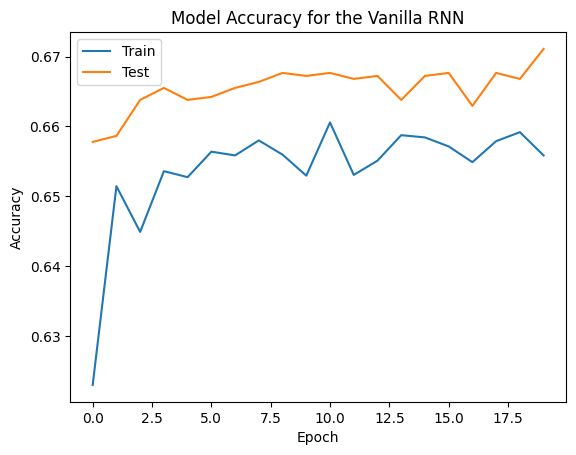

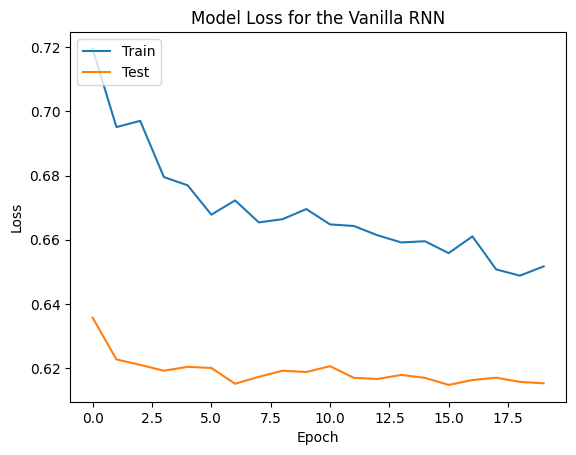

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Test')
plt.title('Model Accuracy for the Vanilla RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Test')
plt.title('Model Loss for the Vanilla RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

LSTM -> New Try

In [76]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.layers import Input, Add, concatenate, Dense, Activation, BatchNormalization, Dropout, Flatten
from keras.layers import LeakyReLU, PReLU, Lambda, Multiply
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from keras.layers import Dense, Dropout, Activation, SimpleRNN

In [28]:
LSTM_dataset = airline[['customer_review','recommended']]
LSTM_dataset.head()

,customer_review,recommended
0,Flew on Turkish Airlines IAD-IST-KHI and retu...,yes
1,Basel to Cape Town via Istanbul. When I arriv...,no
2,Abu Dhabi to Luxembourg via Istanbul. From AU...,yes
3,The experience with Turkish Airlines has been...,no
4,Houston to Kiev via Istanbul. Fares seem comp...,no


In [29]:
LSTM_dataset.groupby('recommended').describe().T

recommended                                                            no  \
customer_review count                                                3999   
                unique                                               3709   
                top      Review  Flew Dublin to Toronto. Despite all t...   
                freq                                                    2   

recommended                                                           yes  
customer_review count                                                7643  
                unique                                               7171  
                top     The quality of the airline has deteriorated ba...  
                freq                                                    2

In [30]:
LSTM_dataset['text_length'] = LSTM_dataset['customer_review'].map(len)
lb=LabelEncoder()
LSTM_dataset['recommended'] = lb.fit_transform(LSTM_dataset['recommended'])
LSTM_dataset_label = LSTM_dataset['recommended'].values
LSTM_dataset.head()

<ipython-input-30-82d84398984c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_dataset['text_length'] = LSTM_dataset['customer_review'].map(len)
<ipython-input-30-82d84398984c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_dataset['recommended'] = lb.fit_transform(LSTM_dataset['recommended'])


,customer_review,recommended,text_length
0,Flew on Turkish Airlines IAD-IST-KHI and retu...,1,936
1,Basel to Cape Town via Istanbul. When I arriv...,0,297
2,Abu Dhabi to Luxembourg via Istanbul. From AU...,1,535
3,The experience with Turkish Airlines has been...,0,1098
4,Houston to Kiev via Istanbul. Fares seem comp...,0,917


In [31]:
x_train, x_test, y_train, y_test = train_test_split(LSTM_dataset['customer_review'], LSTM_dataset_label, test_size=0.15)

Data Pre-processing

In [32]:
max_len = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

vocab_size = len(set(" ".join(x_train).split()))
max_len = x_train.apply(lambda x: len(x)).max()

In [33]:
tokenizer = Tokenizer(num_words = vocab_size)
#char_level = False,
#oov_token = oov_tok
tokenizer.fit_on_texts(x_train)

In [34]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

22338

In [35]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len)
#padding = padding_type,
#truncating = trunc_type

In [36]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len)

In [37]:
vocab_size = 200
embedding_dim = 16
drop_value = 0.2
n_dense = 24

In [77]:
RNN_model = Sequential()
RNN_model.add(Embedding(vocab_size, 100, input_length=max_len))
RNN_model.add(SimpleRNN(50))
RNN_model.add(Dense(1, activation='sigmoid'))
RNN_model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = 'accuracy')

In [78]:
RNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3593, 100)         20000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                7550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 27,601
Trainable params: 27,601
Non-trainable params: 0
_________________________________________________________________


In [79]:
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = RNN_model.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2,batch_size=64)

Epoch 1/40


KeyboardInterrupt: ignored

In [38]:
# Define parameter
n_lstm = 64
drop_lstm = 0.4
# Define LSTM Model
LSTM_model = Sequential()
LSTM_model.add(Embedding(vocab_size, 100, input_length=max_len))
LSTM_model.add(LSTM(64))
LSTM_model.add(Dropout(0.5))
LSTM_model.add(BatchNormalization())
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = 'accuracy')

In [39]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3593, 100)         20000     
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [40]:
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = LSTM_model.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2,batch_size=64)

Epoch 1/40
155/155 - 54s - loss: 0.6948 - accuracy: 0.5510 - val_loss: 0.6697 - val_accuracy: 0.6497 - 54s/epoch - 351ms/step
Epoch 2/40
155/155 - 31s - loss: 0.5843 - accuracy: 0.6872 - val_loss: 0.5990 - val_accuracy: 0.7739 - 31s/epoch - 200ms/step
Epoch 3/40
155/155 - 31s - loss: 0.4448 - accuracy: 0.8079 - val_loss: 0.4860 - val_accuracy: 0.8214 - 31s/epoch - 200ms/step
Epoch 4/40
155/155 - 26s - loss: 0.4055 - accuracy: 0.8276 - val_loss: 0.6674 - val_accuracy: 0.6554 - 26s/epoch - 166ms/step
Epoch 5/40
155/155 - 24s - loss: 0.4219 - accuracy: 0.8149 - val_loss: 0.4072 - val_accuracy: 0.8266 - 24s/epoch - 155ms/step
Epoch 6/40
155/155 - 23s - loss: 0.3746 - accuracy: 0.8482 - val_loss: 0.3755 - val_accuracy: 0.8357 - 23s/epoch - 151ms/step
Epoch 7/40
155/155 - 21s - loss: 0.3751 - accuracy: 0.8448 - val_loss: 0.3724 - val_accuracy: 0.8346 - 21s/epoch - 135ms/step
Epoch 8/40
155/155 - 20s - loss: 0.3619 - accuracy: 0.8504 - val_loss: 0.3705 - val_accuracy: 0.8420 - 20s/epoch - 132

In [72]:
from sklearn.metrics import classification_report

y_pred = LSTM_model.predict(testing_padded, verbose=1)
y_pred =np.rint(y_pred)
y_pred_bool = y_pred.tolist()
print(classification_report(y_test, y_pred_bool))

55/55 [==============================] - 5s 96ms/step
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       612
           1       0.87      0.88      0.88      1135

    accuracy                           0.84      1747
   macro avg       0.82      0.82      0.82      1747
weighted avg       0.84      0.84      0.84      1747



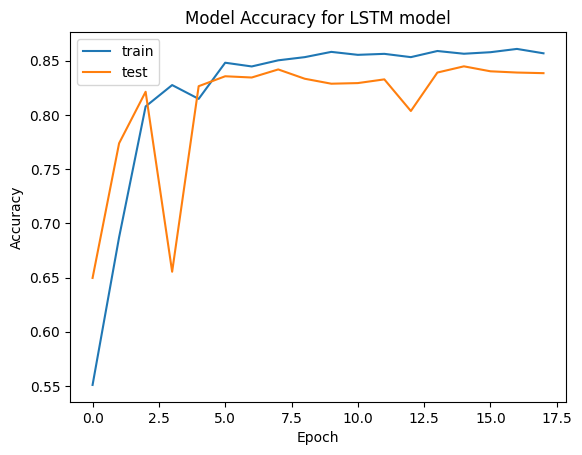

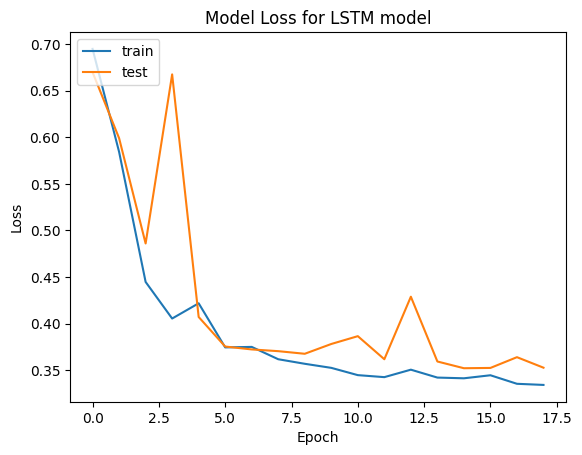

In [71]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy for LSTM model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for LSTM model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
LSTM_Bi_model = Sequential()
LSTM_Bi_model.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
LSTM_Bi_model.add(Bidirectional(LSTM(64,return_sequences = False)))
LSTM_Bi_model.add(Dropout(0.5))
LSTM_Bi_model.add(Dense(64, activation='relu'))
LSTM_Bi_model.add(Dense(1, activation='sigmoid'))

In [ ]:
LSTM_Bi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3593, 16)          3200      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 52,993
Trainable params: 52,993
Non-trainable params: 0
____________________________________________________

In [ ]:
LSTM_Bi_model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = 'accuracy')

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = LSTM_Bi_model.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),batch_size=32, callbacks=[early_stop],
                     verbose = 2)

Epoch 1/30
310/310 - 115s - loss: 0.6562 - accuracy: 0.6466 - val_loss: 0.6253 - val_accuracy: 0.6640 - 115s/epoch - 369ms/step
Epoch 2/30
310/310 - 78s - loss: 0.5588 - accuracy: 0.7067 - val_loss: 0.4633 - val_accuracy: 0.7813 - 78s/epoch - 252ms/step
Epoch 3/30
310/310 - 69s - loss: 0.4354 - accuracy: 0.8027 - val_loss: 0.3884 - val_accuracy: 0.8311 - 69s/epoch - 223ms/step
Epoch 4/30
310/310 - 67s - loss: 0.3800 - accuracy: 0.8394 - val_loss: 0.3711 - val_accuracy: 0.8311 - 67s/epoch - 216ms/step
Epoch 5/30
310/310 - 62s - loss: 0.3605 - accuracy: 0.8495 - val_loss: 0.3640 - val_accuracy: 0.8351 - 62s/epoch - 201ms/step
Epoch 6/30
310/310 - 60s - loss: 0.3489 - accuracy: 0.8525 - val_loss: 0.3459 - val_accuracy: 0.8466 - 60s/epoch - 195ms/step
Epoch 7/30
310/310 - 62s - loss: 0.3411 - accuracy: 0.8601 - val_loss: 0.3459 - val_accuracy: 0.8523 - 62s/epoch - 199ms/step
Epoch 8/30
310/310 - 59s - loss: 0.3362 - accuracy: 0.8618 - val_loss: 0.3531 - val_accuracy: 0.8529 - 59s/epoch - 1

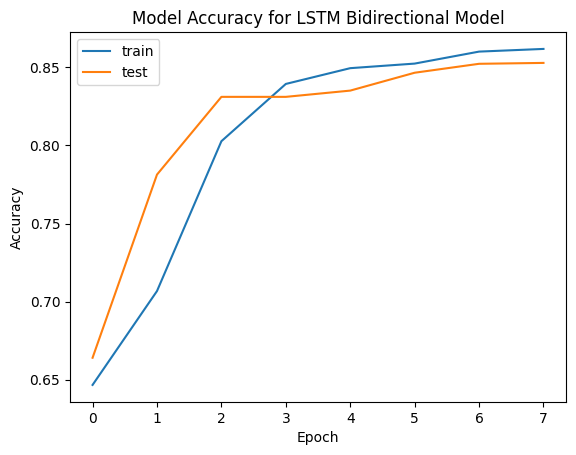

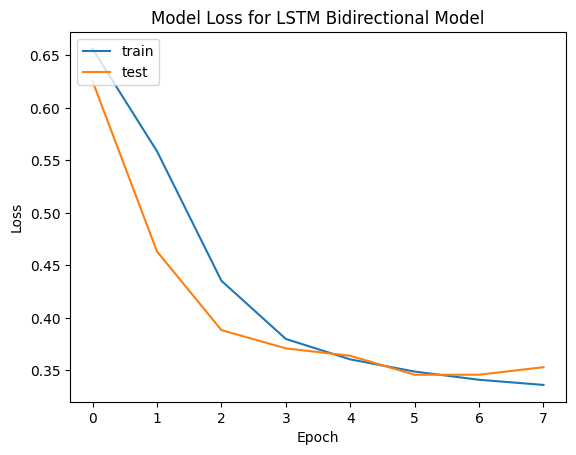

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy for LSTM Bidirectional Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for LSTM Bidirectional Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model2.save('/content/drive/MyDrive/sample_data/Thesis/Model/')

In [ ]:
LSTM_Bi_model.save('/content/drive/MyDrive/sample_data/Thesis/Model_LSTM/')

In [55]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/sample_data/Thesis/Model_LSTM/')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3593, 16)          3200      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 52,993
Trainable params: 52,993
Non-trainable params: 0
____________________________________________________

In [73]:
from sklearn.metrics import classification_report

y_pred = loaded_model.predict(testing_padded, verbose=1)
y_pred =np.rint(y_pred)
y_pred_bool = y_pred.tolist()
print(classification_report(y_test, y_pred_bool))

55/55 [==============================] - 7s 116ms/step
              precision    recall  f1-score   support

           0       0.69      0.38      0.49       612
           1       0.73      0.91      0.81      1135

    accuracy                           0.72      1747
   macro avg       0.71      0.64      0.65      1747
weighted avg       0.72      0.72      0.70      1747

